### *DS 261: AI for Medical Image Analysis : Assignment 02*
*Submitted By: Aman Pawar, Mtech (1st Year), SR NO: 22761, Department of Bioengineering* 

*Note: Please install the following libraries if not already installed*

*Necessary Installs*<br/>
```!pip install numpy scipy matplotlib sklearn tqdm torchmetrics``` <br/>
```!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118```<br/>

*Installs for better visualizations*<br/>
```!pip install torchsummary graphviz torchview``` *Note on Windows you must install executable of graphviz*<br/> 

### *Task-2 : Create a Model for Segementing the CT Scan Images*

In [1]:
# Doing necessary imports
import gc
import scipy.io
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]=1200
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchmetrics as tm
from torchsummary import summary
from torchview import draw_graph
from torch.utils.data import Dataset, DataLoader, random_split

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Working on {device}")

Working on cuda


In [2]:
# Building necessary Functions

def read_data(path):
    """Function to read data"""
    mat = scipy.io.loadmat(path)
    image_data = mat[list(mat.keys())[-1]]
    print("Reading Data...")
    print(f"Resolution of CT image : {image_data.shape[:2]} ")
    print(f"The number of CT images : {image_data.shape[2]}\n")
    return image_data

def visualize_data(data):
    """Function to visualize data"""
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, it in enumerate([100, 125, 150, 175, 200]): # Choosen Random images for display
        axes[i].imshow(data[:,:,it], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(get_object_name(data)+f'{i}')
    plt.show()

def get_object_name(obj):
    """Function to return name of object"""
    for name, value in globals().items():
        if value is obj:
            return name
    return None

def infection_ratio_cluster(data_ct, data_mask):
    """Function to compute the infection Ratio and cluster in 3 groups"""
    Normal_ct, Mild_ct, Severe_ct = [], [], []
    Normal_mask, Mild_mask, Severe_mask = [], [], []

    for i in range(data_mask.shape[2]):
        slice_data_mask = data_mask[:, :, i]
        slice_data_ct = data_ct[:,:,i]
        total_pixels = (slice_data_mask > 0).sum()
        infected_pixels = ((slice_data_mask > 0) & (slice_data_mask < 2)).sum()
        infection_ratio = infected_pixels / total_pixels * 100

        # Categorize the slice based on the infection ratio
        if infection_ratio == 0:
            Normal_mask.append(slice_data_mask)
            Normal_ct.append(slice_data_ct)
        elif 0 < infection_ratio <= 40:
            Mild_mask.append(slice_data_mask)
            Mild_ct.append(slice_data_ct)
        else:
            Severe_mask.append(slice_data_mask)
            Severe_ct.append(slice_data_ct)

    return np.array(Normal_mask), np.array(Normal_ct), np.array(Mild_mask), np.array(Mild_ct), np.array(Severe_mask), np.array(Severe_ct)

class CustomImageDataset_seg(Dataset):
    def __init__(self, data, masks, transform=None):
        self.data = data
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        masks = self.masks[index]

        if self.transform:
            image = self.transform(image)

        return image, masks

Reading Data...
Resolution of CT image : (512, 512) 
The number of CT images : 3554

Reading Data...
Resolution of CT image : (512, 512) 
The number of CT images : 3554

Plotting CT Scan Data...


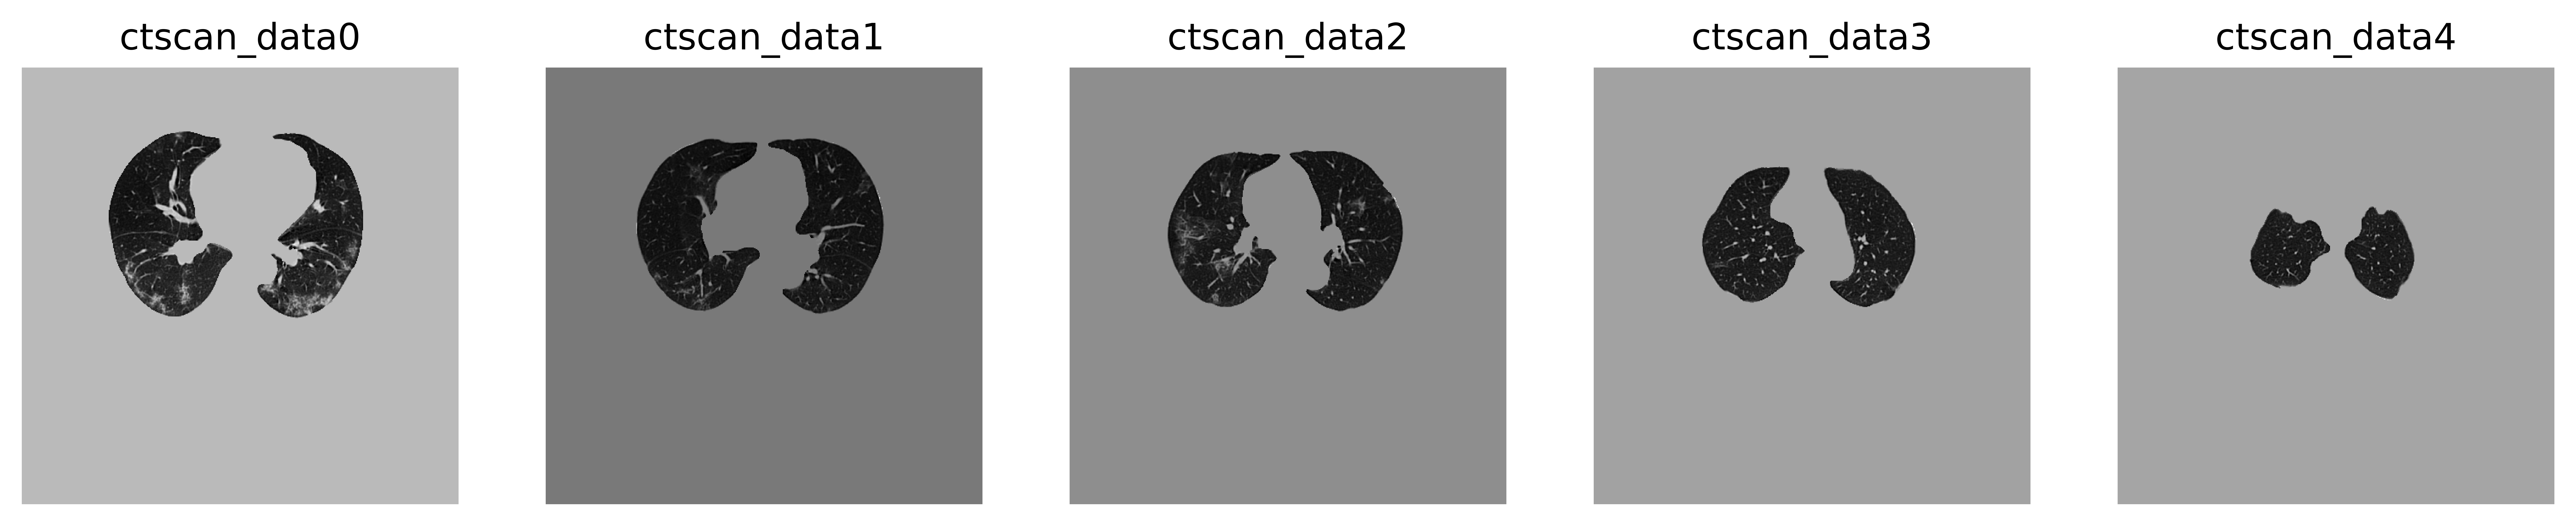

Plotting Coresponding Mask Data...


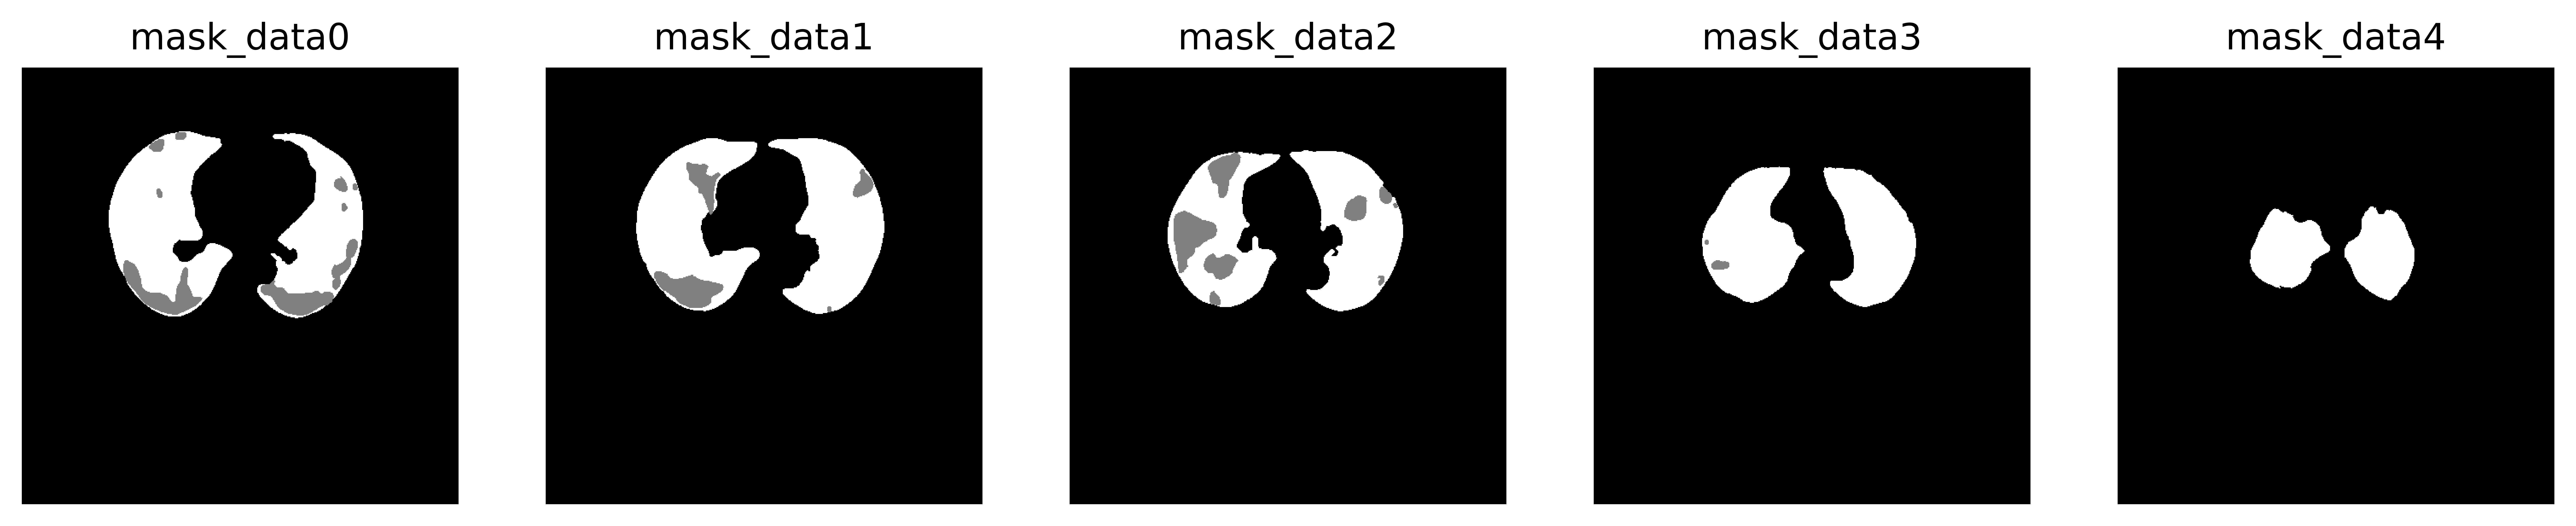

In [3]:
# Setting the path
path_ctscan = '/home/user2/AIMIA_AmanPawar/ctscan_hw1.mat'
path_mask = '/home/user2/AIMIA_AmanPawar/infmsk_hw1.mat'

# Reading the data
ctscan_data = read_data(path_ctscan)
mask_data = read_data(path_mask)

# Visualizing the Data
print(f"Plotting CT Scan Data...")
visualize_data(ctscan_data)
print(f"Plotting Coresponding Mask Data...")
visualize_data(mask_data)

In [4]:
# Clustering the data as per the infection ratio
Normal_mask, Normal_ct, Mild_mask, Mild_ct, Severe_mask, Severe_ct = infection_ratio_cluster(ctscan_data, mask_data)
print(f"Number of Normal CT : {len(Normal_mask)}\nNumber of Mild CT : {len(Mild_mask)}\nNumber of Severe CT : {len(Severe_mask)}")

# Free Ram
del ctscan_data, mask_data
gc.collect()

Number of Normal CT : 1441
Number of Mild CT : 1954
Number of Severe CT : 159


22100

#### *Split the CT dataset into 70% training, 10% validation, and 20% testing*

In [5]:
# Preparing the dataset for segementation

# Concatenate the CT and mask images
all_images = np.concatenate((Normal_ct, Mild_ct, Severe_ct), axis=0)
all_masks = np.concatenate((Normal_mask, Mild_mask, Severe_mask), axis=0)

print(f"All Images : {all_images.shape}, Masks : {all_masks.shape}")


transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.0,), (1.0,))  # Rescale pixel values to the range [0, 1]
])

dataset = CustomImageDataset_seg(all_images, all_masks, transform=transform)
# Define the sizes for the training and testing sets
train_size = int(0.7 * len(dataset))
temp_size = len(dataset) - train_size
val_size = int(1/3 * temp_size)
test_size = temp_size - val_size

train_dataset, temp_dataset = random_split(dataset, [train_size, temp_size])
valid_dataset, test_dataset = random_split(temp_dataset, [val_size, test_size])

# Data Loaders
batch_size = 96
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Free Memory
del all_images, all_masks
gc.collect()

All Images : (3554, 512, 512), Masks : (3554, 512, 512)


0

In [6]:
print("Visualtizing Data from the DataLoader...")
data_iterator = iter(train_loader)
batch = next(data_iterator)
images, labels = batch

images = images.cpu().numpy()
labels = labels.numpy()

# Display the first 5 images in a horizontal layout
plt.figure(figsize=(15, 7))
# Plot images
for i in range(5):
    plt.subplot(2, 5, i + 1)  # First row for images
    image = images[i]
    image = np.moveaxis(image, 0, -1)  # Transpose to HWC format
    plt.imshow(image, cmap="gray")
    plt.title(f"Image_{i+1}")
    plt.axis('off')

# Plot masks
for i in range(5):
    plt.subplot(2, 5, i + 6)  # Second row for masks
    label = labels[i]
    # label = np.moveaxis(label, 0, -1)
    plt.imshow(label, cmap="gray")
    plt.title(f"Mask_{i+1}")
    plt.axis('off')

plt.show()

del images, labels
gc.collect()

Visualtizing Data from the DataLoader...


22203

#### *Defining a U-Net Model for Segementation*

In [7]:
# Defining the the U-Net Architecture
class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

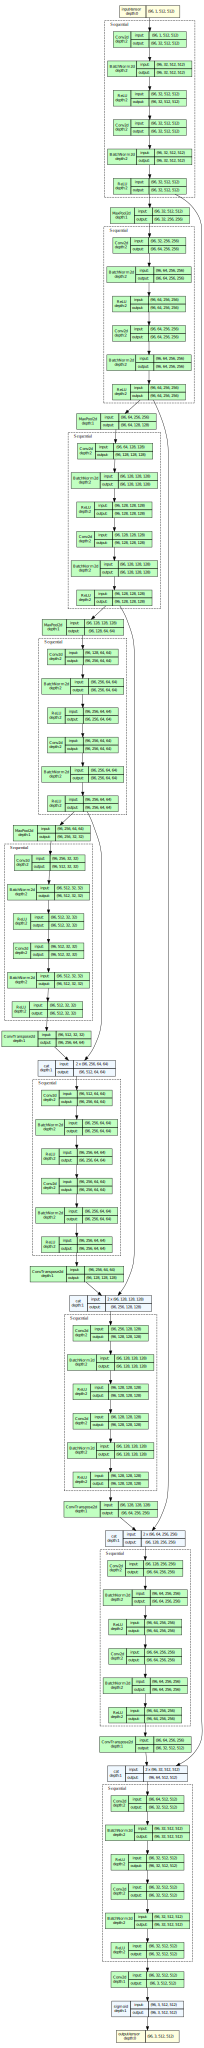

In [8]:
model = UNet(in_channels=1, out_channels=3)
model_graph = draw_graph(model, input_size=(96, 1, 512, 512), expand_nested=True)
model_graph.visual_graph

In [9]:
summary(model, (1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             288
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 32, 512, 512]           9,216
       BatchNorm2d-5         [-1, 32, 512, 512]              64
              ReLU-6         [-1, 32, 512, 512]               0
         MaxPool2d-7         [-1, 32, 256, 256]               0
            Conv2d-8         [-1, 64, 256, 256]          18,432
       BatchNorm2d-9         [-1, 64, 256, 256]             128
             ReLU-10         [-1, 64, 256, 256]               0
           Conv2d-11         [-1, 64, 256, 256]          36,864
      BatchNorm2d-12         [-1, 64, 256, 256]             128
             ReLU-13         [-1, 64, 256, 256]               0
        MaxPool2d-14         [-1, 64, 1

In [10]:
#For parellel training
model= nn.DataParallel(model)
model = model.to(device)

#Define your loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.85,2.25,1.25])).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation loop
num_epochs = 10  # Specify the number of epochs

# Lists to store training and validation loss and accuracy values for plotting
train_loss_history = []
train_accuracy_history = []
valid_loss_history = []
valid_accuracy_history = []
train_dice_history = []
valid_dice_history = []

# Set up model checkpointing
best_valid_accuracy = 0.0
checkpoint_path = '/home/user2/AIMIA_AmanPawar/model_weights/unet_checkpoint.pth'

acc_ = tm.Accuracy(task="multiclass", num_classes=3).to(device)
dice = tm.classification.Dice(average='micro').to(device)

Epoch 1/Validation: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s, accuracy=83.9, dice_score=0.83880776, loss=0.866]


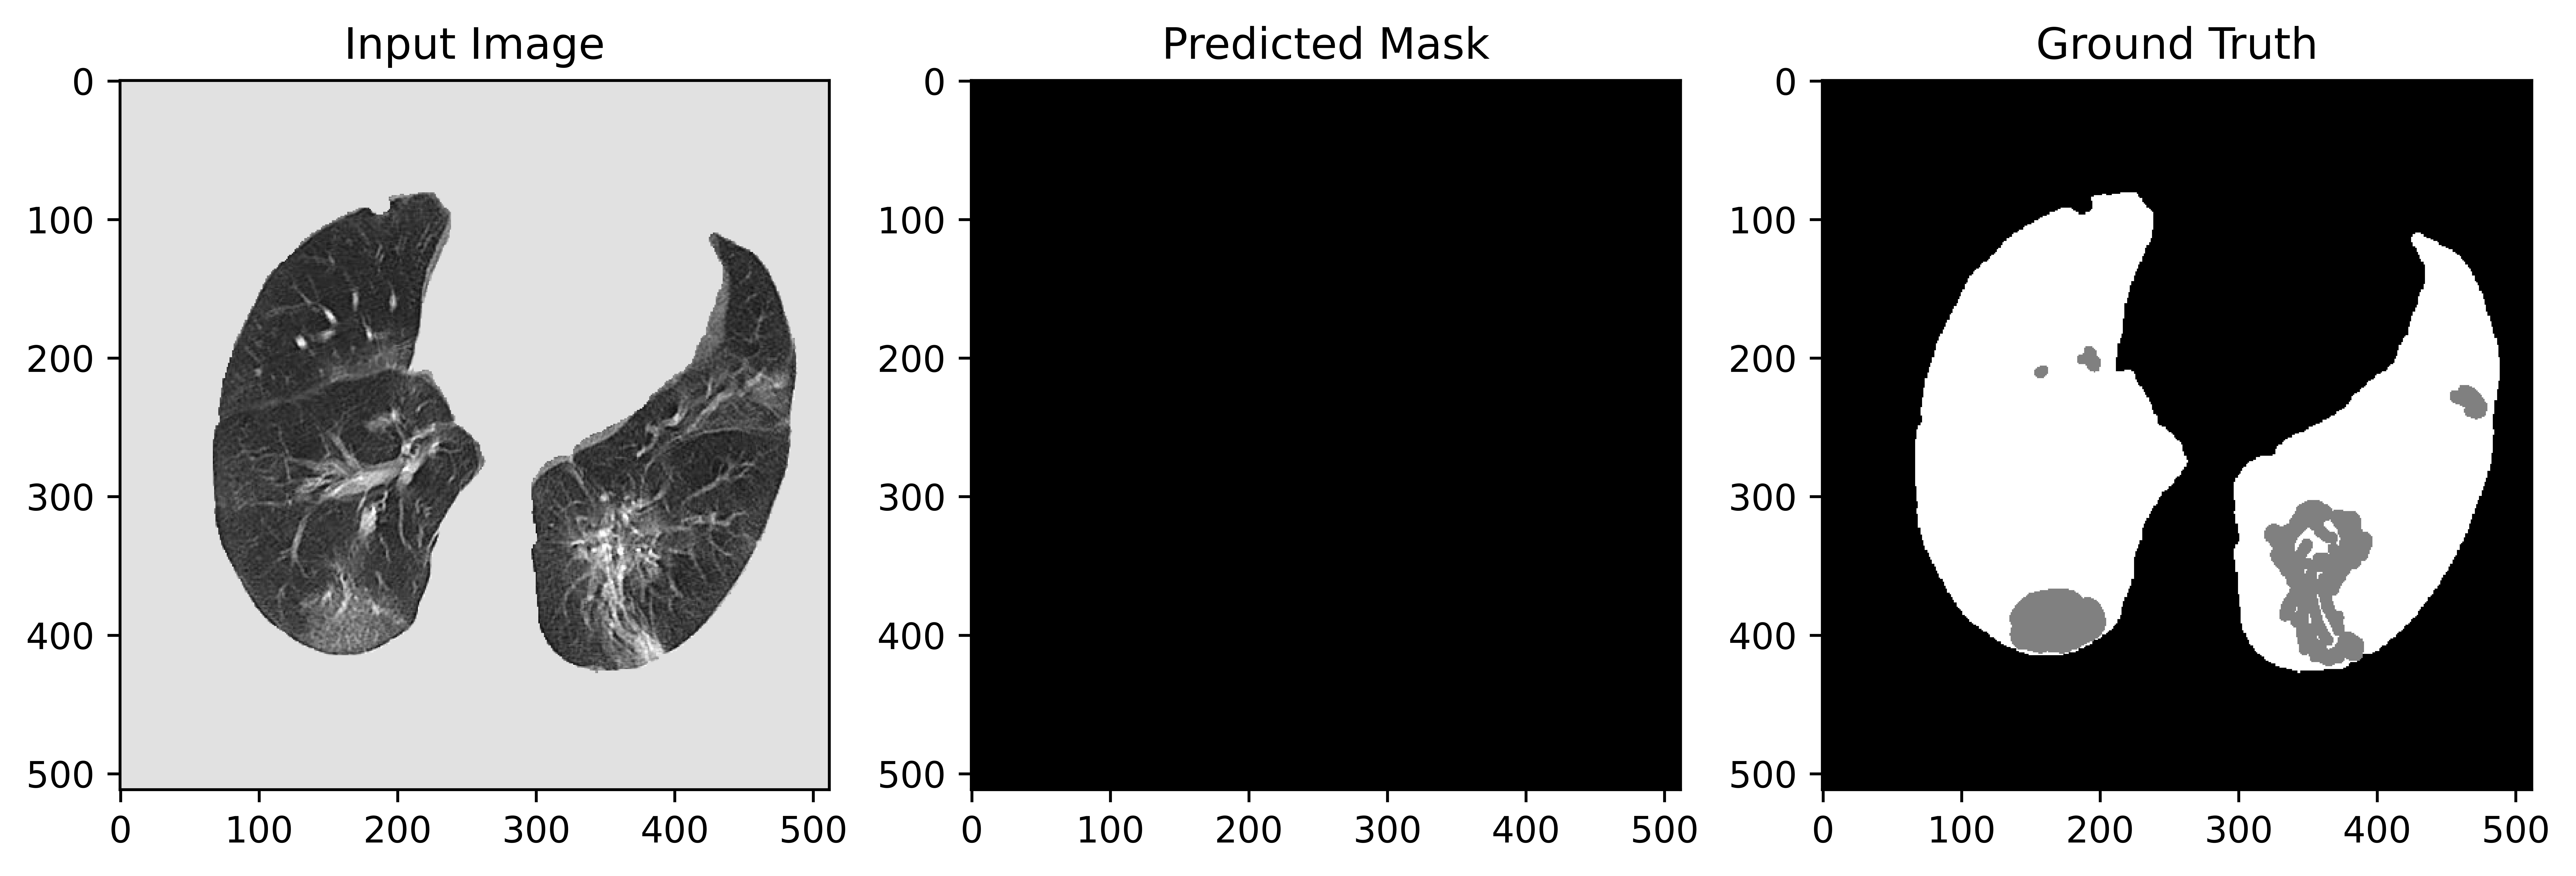

Epoch 3/Validation: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s, accuracy=99.1, dice_score=0.9910761, loss=0.499] 


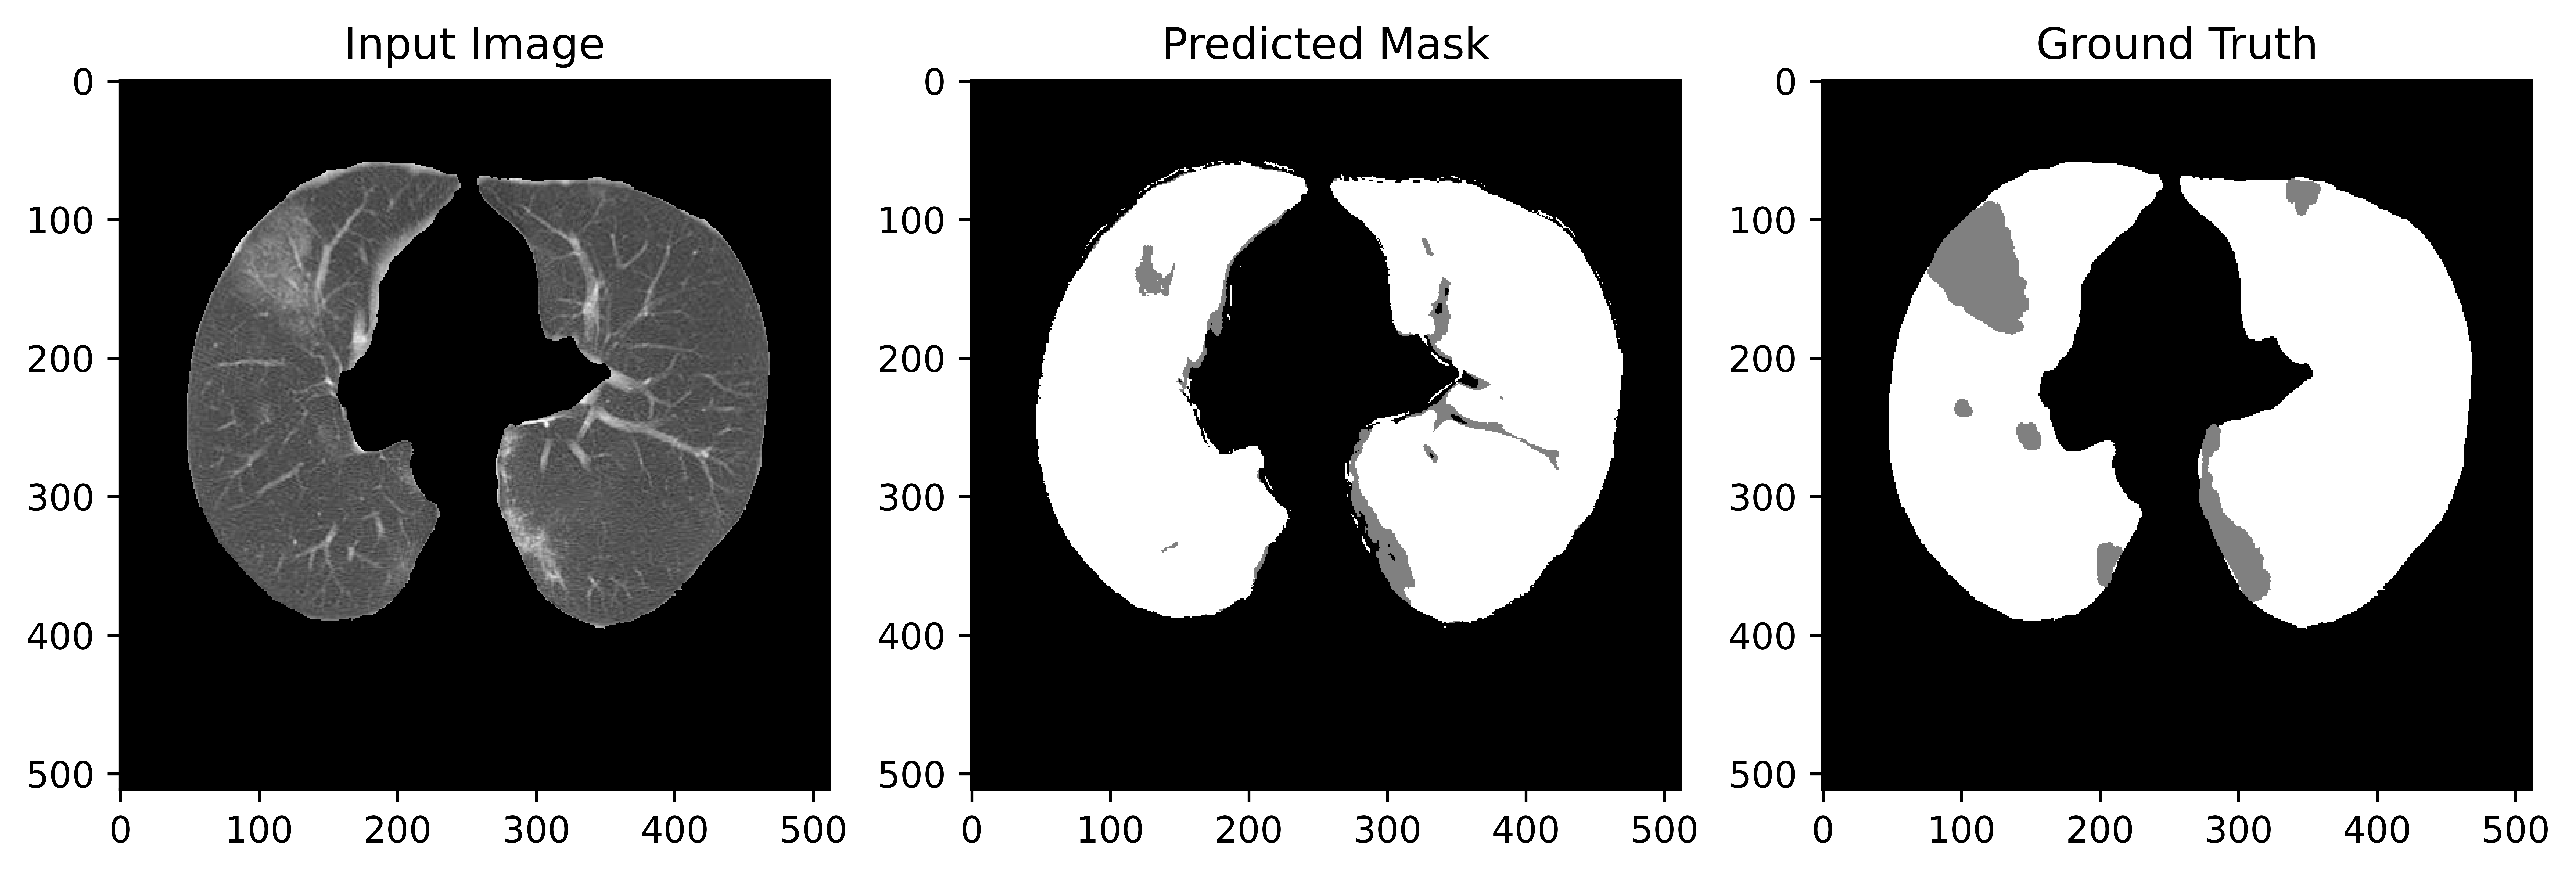

Epoch 5/Validation: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s, accuracy=98.4, dice_score=0.9844021, loss=0.394]


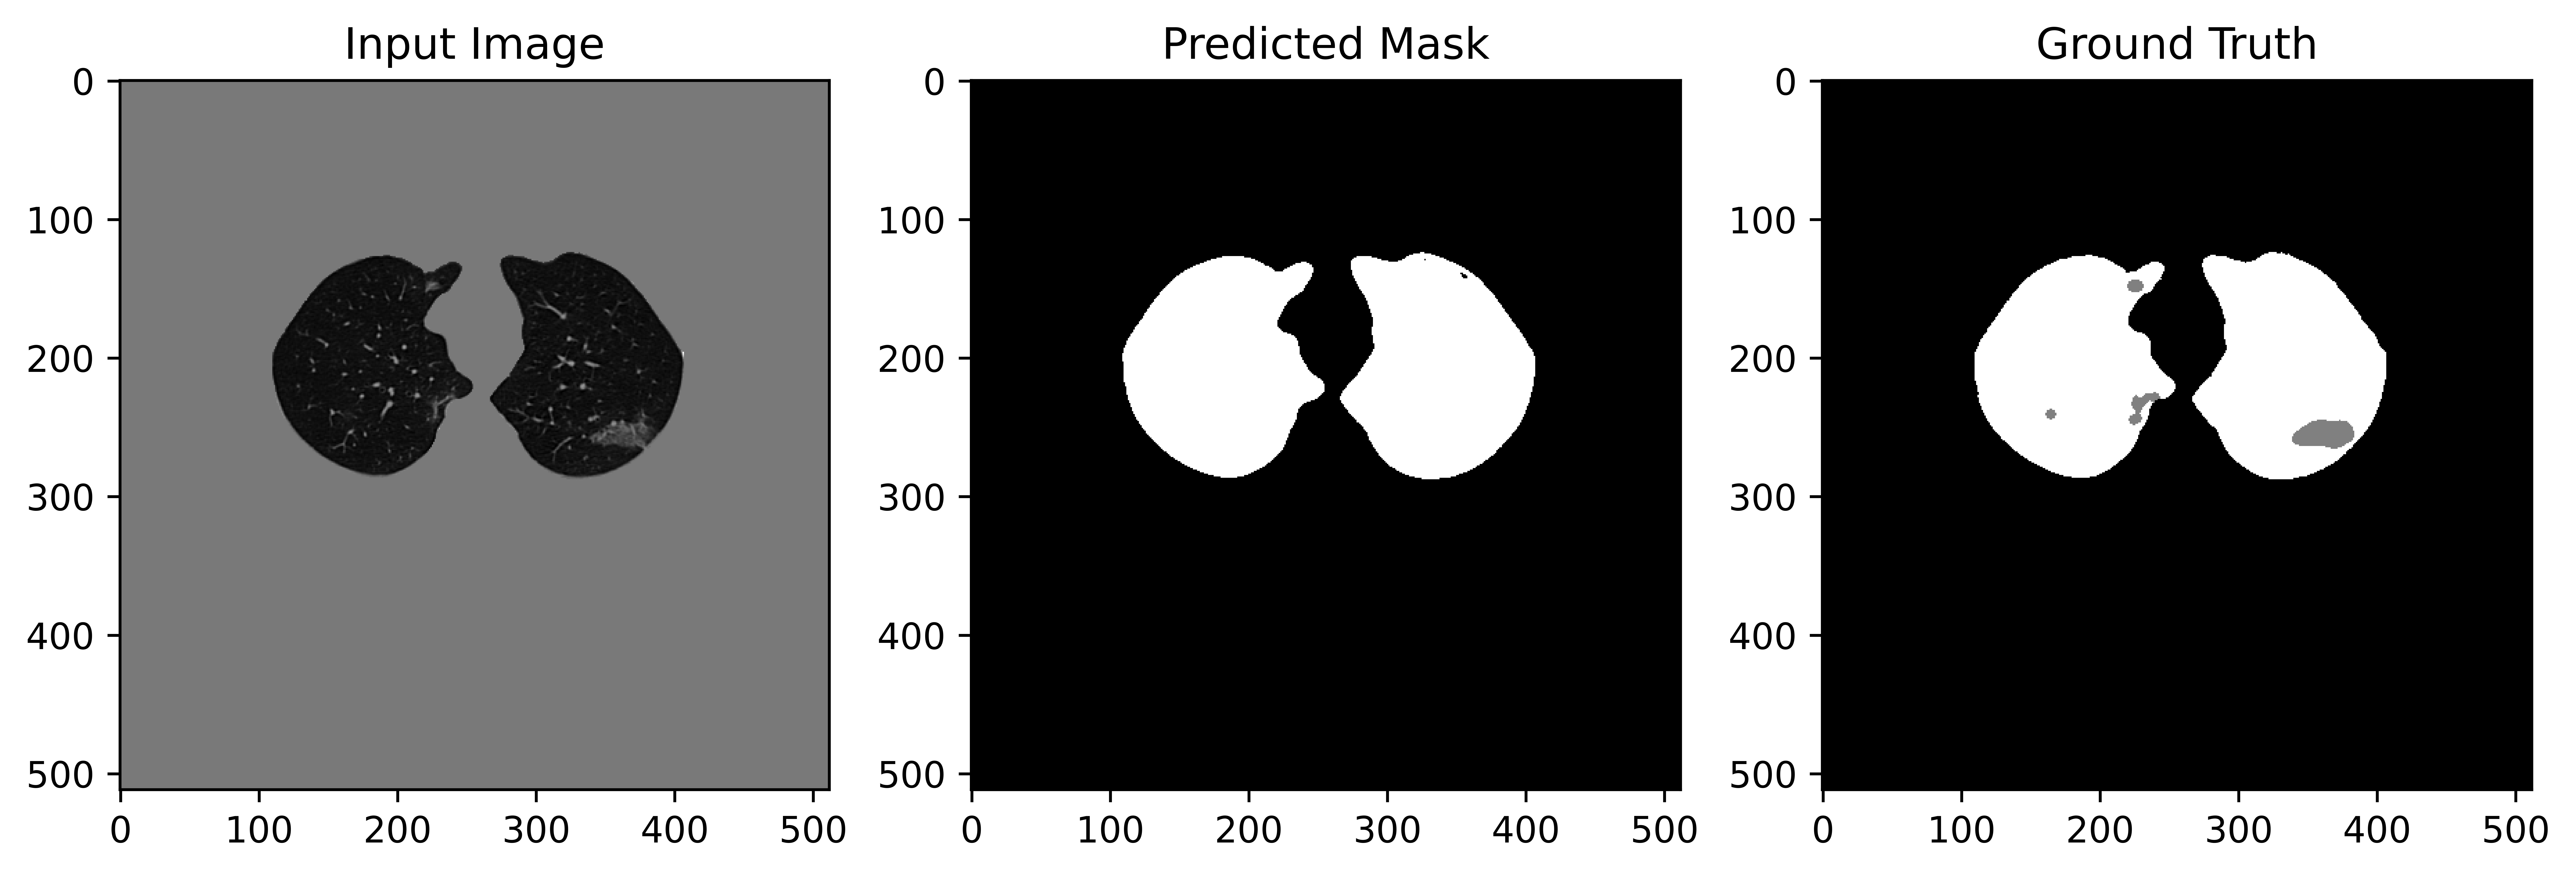

Epoch 7/Validation: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s, accuracy=98.9, dice_score=0.9892666, loss=0.329] 


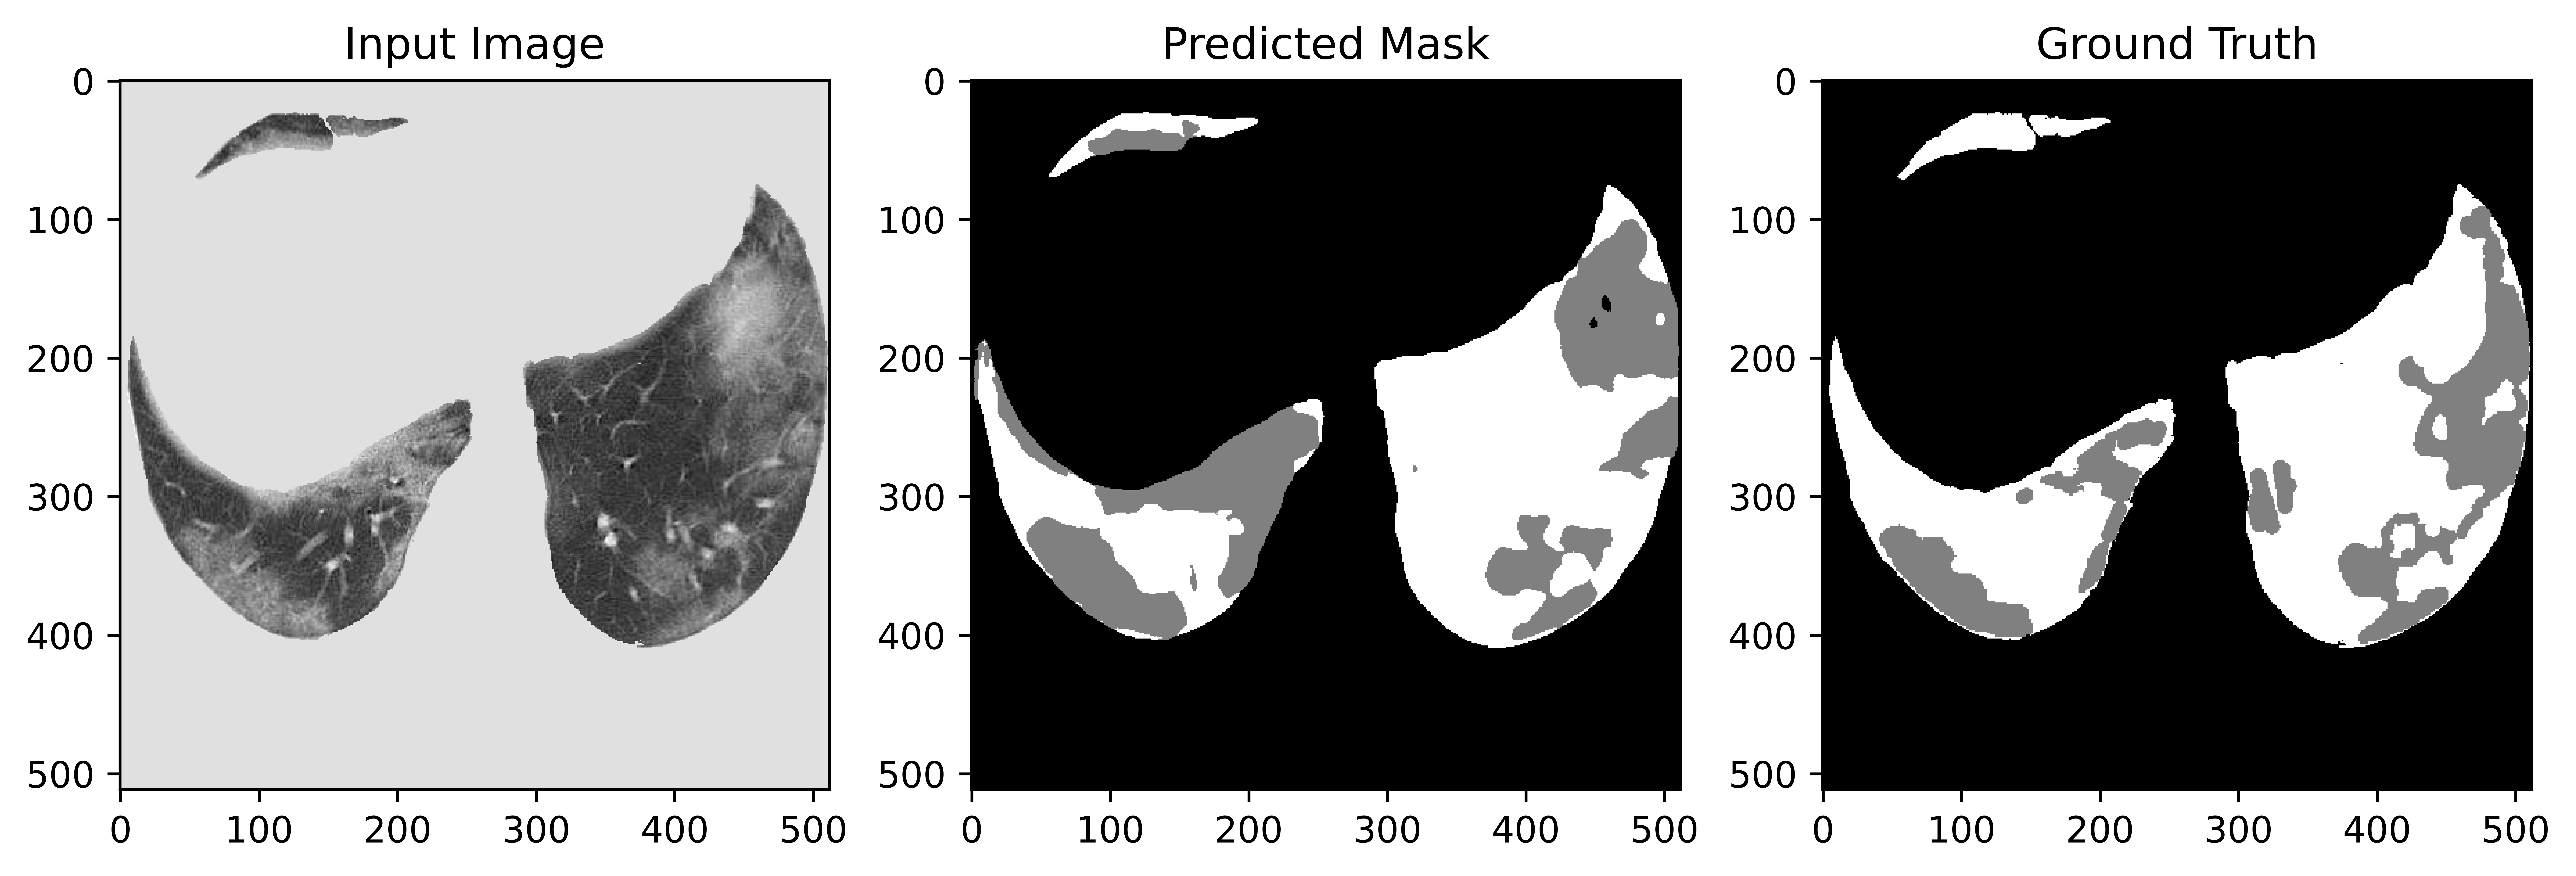

Epoch 9/Validation: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s, accuracy=99.5, dice_score=0.9947381, loss=0.304]


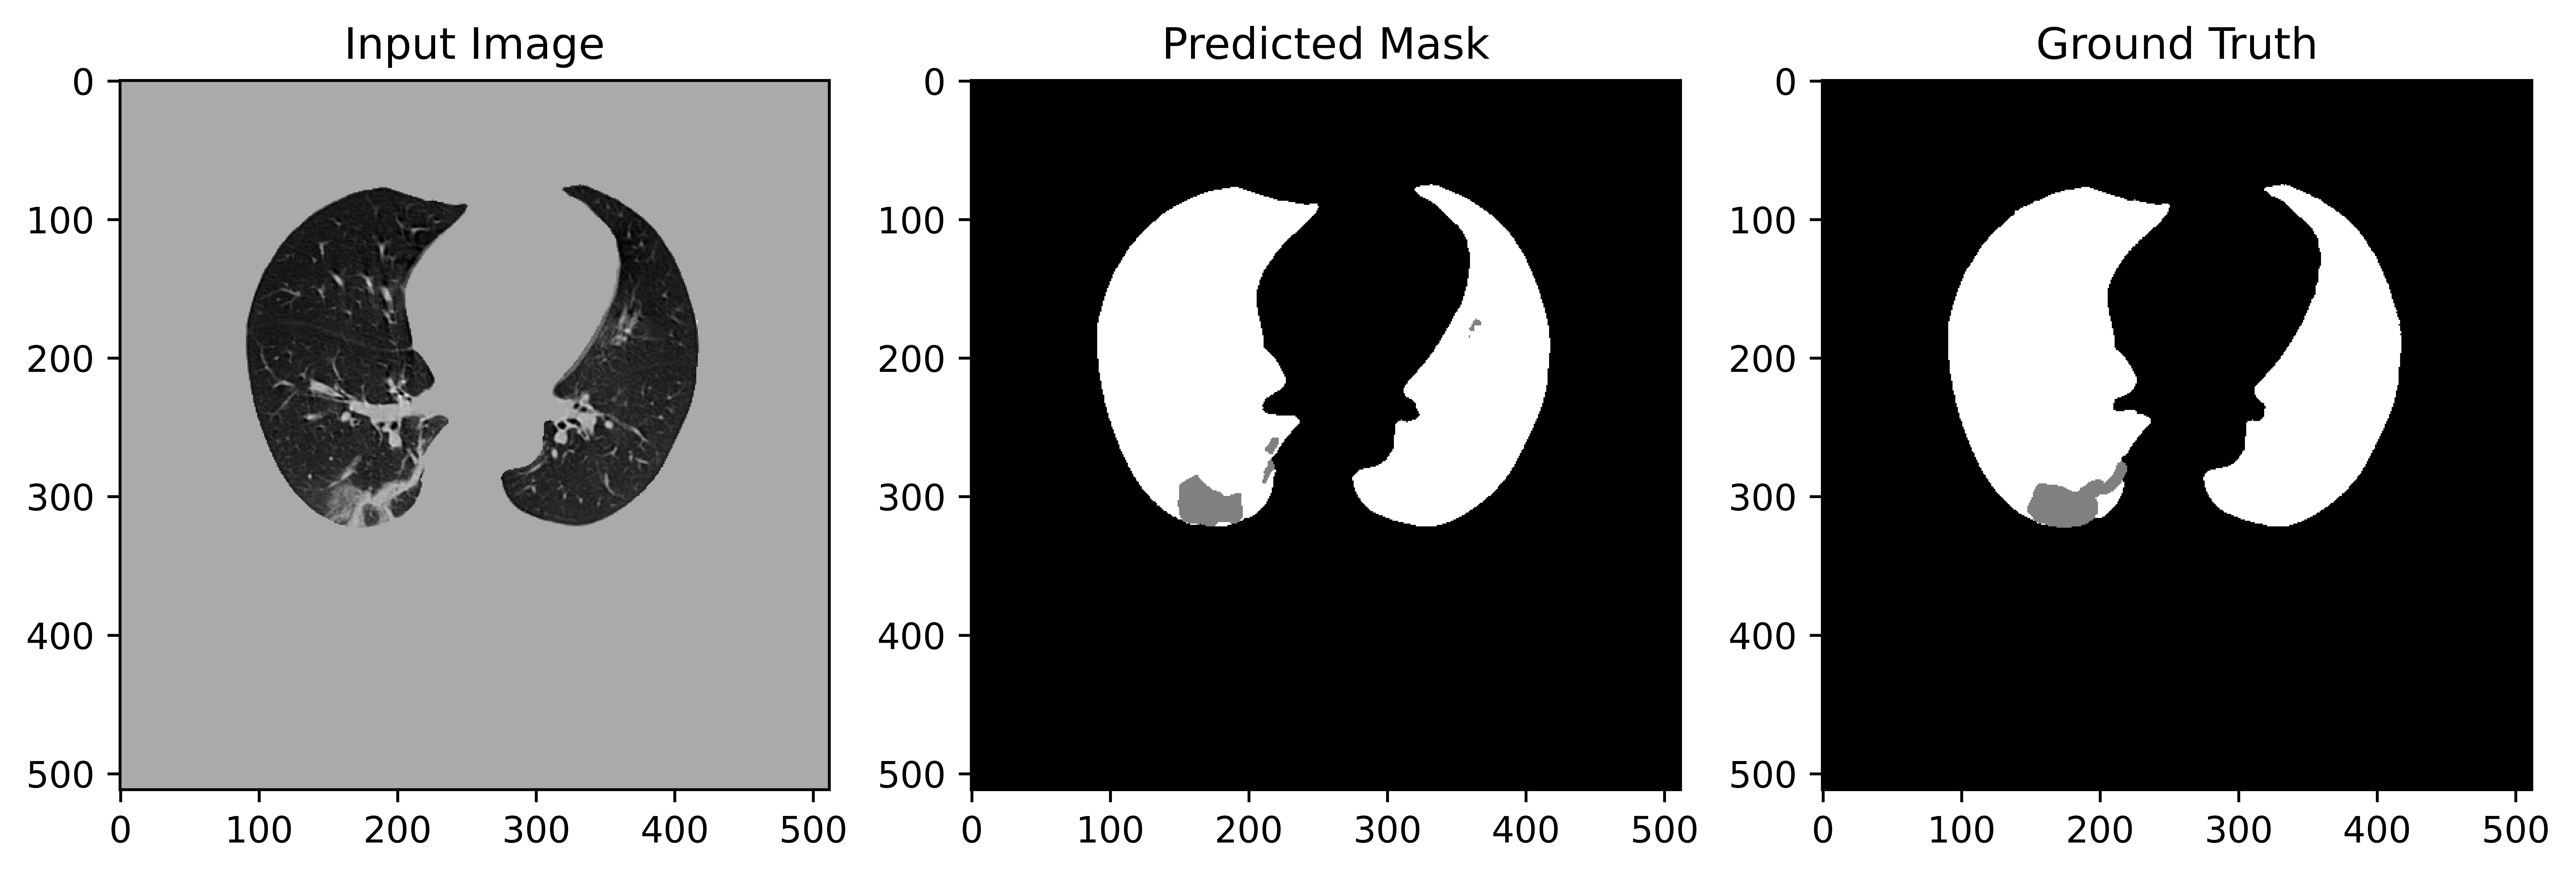

Epoch 10/Validation: 100%|██████████| 4/4 [00:02<00:00,  1.60it/s, accuracy=99.3, dice_score=0.9926988, loss=0.294] 

CPU times: user 44min 25s, sys: 1h 42min 9s, total: 2h 26min 35s
Wall time: 8min 13s


In [12]:
%%time
# Training loop with tqdm
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0

    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch + 1}/Training', position=0)
    for i, (images, masks) in enumerate(train_loader_iter):
        images = images.to(device)
        masks = masks.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs*2.
        # outputs = torch.argmax(outputs, 1)

        loss = criterion(outputs.type(torch.float), masks)
        # loss.requires_grad = True
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
        

        train_loss = train_running_loss / (i + 1)
        train_accuracy = 100*acc_(outputs, masks).cpu().numpy()
        
        # Calculate Dice Score
        dice_score_train = dice(outputs, masks.type(torch.int)).cpu().numpy()
        
        train_loader_iter.set_postfix(loss=train_loss, accuracy=train_accuracy, dice_score=dice_score_train)

        del images, masks, outputs
        torch.cuda.empty_cache()
        gc.collect()

    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
    train_dice_history.append(dice_score_train)
    
    # Validation loop with tqdm
    model.eval()
    valid_running_loss = 0.0

    valid_loader_iter = tqdm(valid_loader, desc=f'Epoch {epoch + 1}/Validation', position=0)
    with torch.no_grad():
        for i, (images, masks) in enumerate(valid_loader_iter):
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(images)
            outputs = outputs*2.
            # outputs = torch.argmax(outputs,1)
            
            loss = criterion(outputs.type(torch.float), masks)
            # loss.requires_grad = True
            valid_running_loss += loss.item()

            valid_loss = valid_running_loss / (i + 1)
            valid_accuracy = 100 * acc_(outputs, masks).cpu().numpy()
            
            # Calculate Dice Score
            dice_score_valid = dice(outputs, masks.type(torch.int)).cpu().numpy()
            
            valid_loader_iter.set_postfix(loss=valid_loss, accuracy=valid_accuracy, dice_score=dice_score_valid)
            del images, masks, outputs
            torch.cuda.empty_cache()
            gc.collect()

    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    valid_dice_history.append(dice_score_valid)
    
    # Save the model checkpoint if the current validation accuracy is the best so far
    if valid_accuracy > best_valid_accuracy:
        best_valid_accuracy = valid_accuracy
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_valid_accuracy': best_valid_accuracy,
        }
        torch.save(checkpoint, checkpoint_path)
        
    if epoch%2==0:
        # Display input image, predicted mask, and ground truth
        sample_images, sample_masks = next(iter(valid_loader))  # You can change this to use a different batch
        sample_images = sample_images.to(device)
        sample_masks = sample_masks.to(device)

        with torch.no_grad():
            sample_outputs = model(sample_images)

        # Prininting a sample after a epoch
        i = np.random.randint(0, sample_images.shape[0])
        input_image = sample_images[i].cpu().numpy()
        predicted_mask = sample_outputs[i].cpu().numpy()
        ground_truth = sample_masks[i].cpu().numpy()
        
        # predicted_mask = np.transpose(predicted_mask, (1,2,0))
        predicted_mask = np.argmax(predicted_mask, axis=0)
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(input_image[0], cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title('Predicted Mask')
        plt.imshow(predicted_mask, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title('Ground Truth')
        plt.imshow(ground_truth, cmap='gray')
        plt.show()

        del sample_images, sample_masks, sample_outputs
        torch.cuda.empty_cache()
        gc.collect()

In [13]:
# Plot loss and accuracy curves
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history,'--or', markersize=2, label='Training Loss')
plt.plot(valid_loss_history,'--ob', markersize=2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history,'--or', markersize=2, label='Training Accuracy')
plt.plot(valid_accuracy_history,'--ob', markersize=2, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Testing: 100%|██████████| 8/8 [01:11<00:00,  8.92s/it]


Accuracy: 99.39%
Sensitivity: 0.99
Specificity: 1.00
Avg Dice Score: 0.99


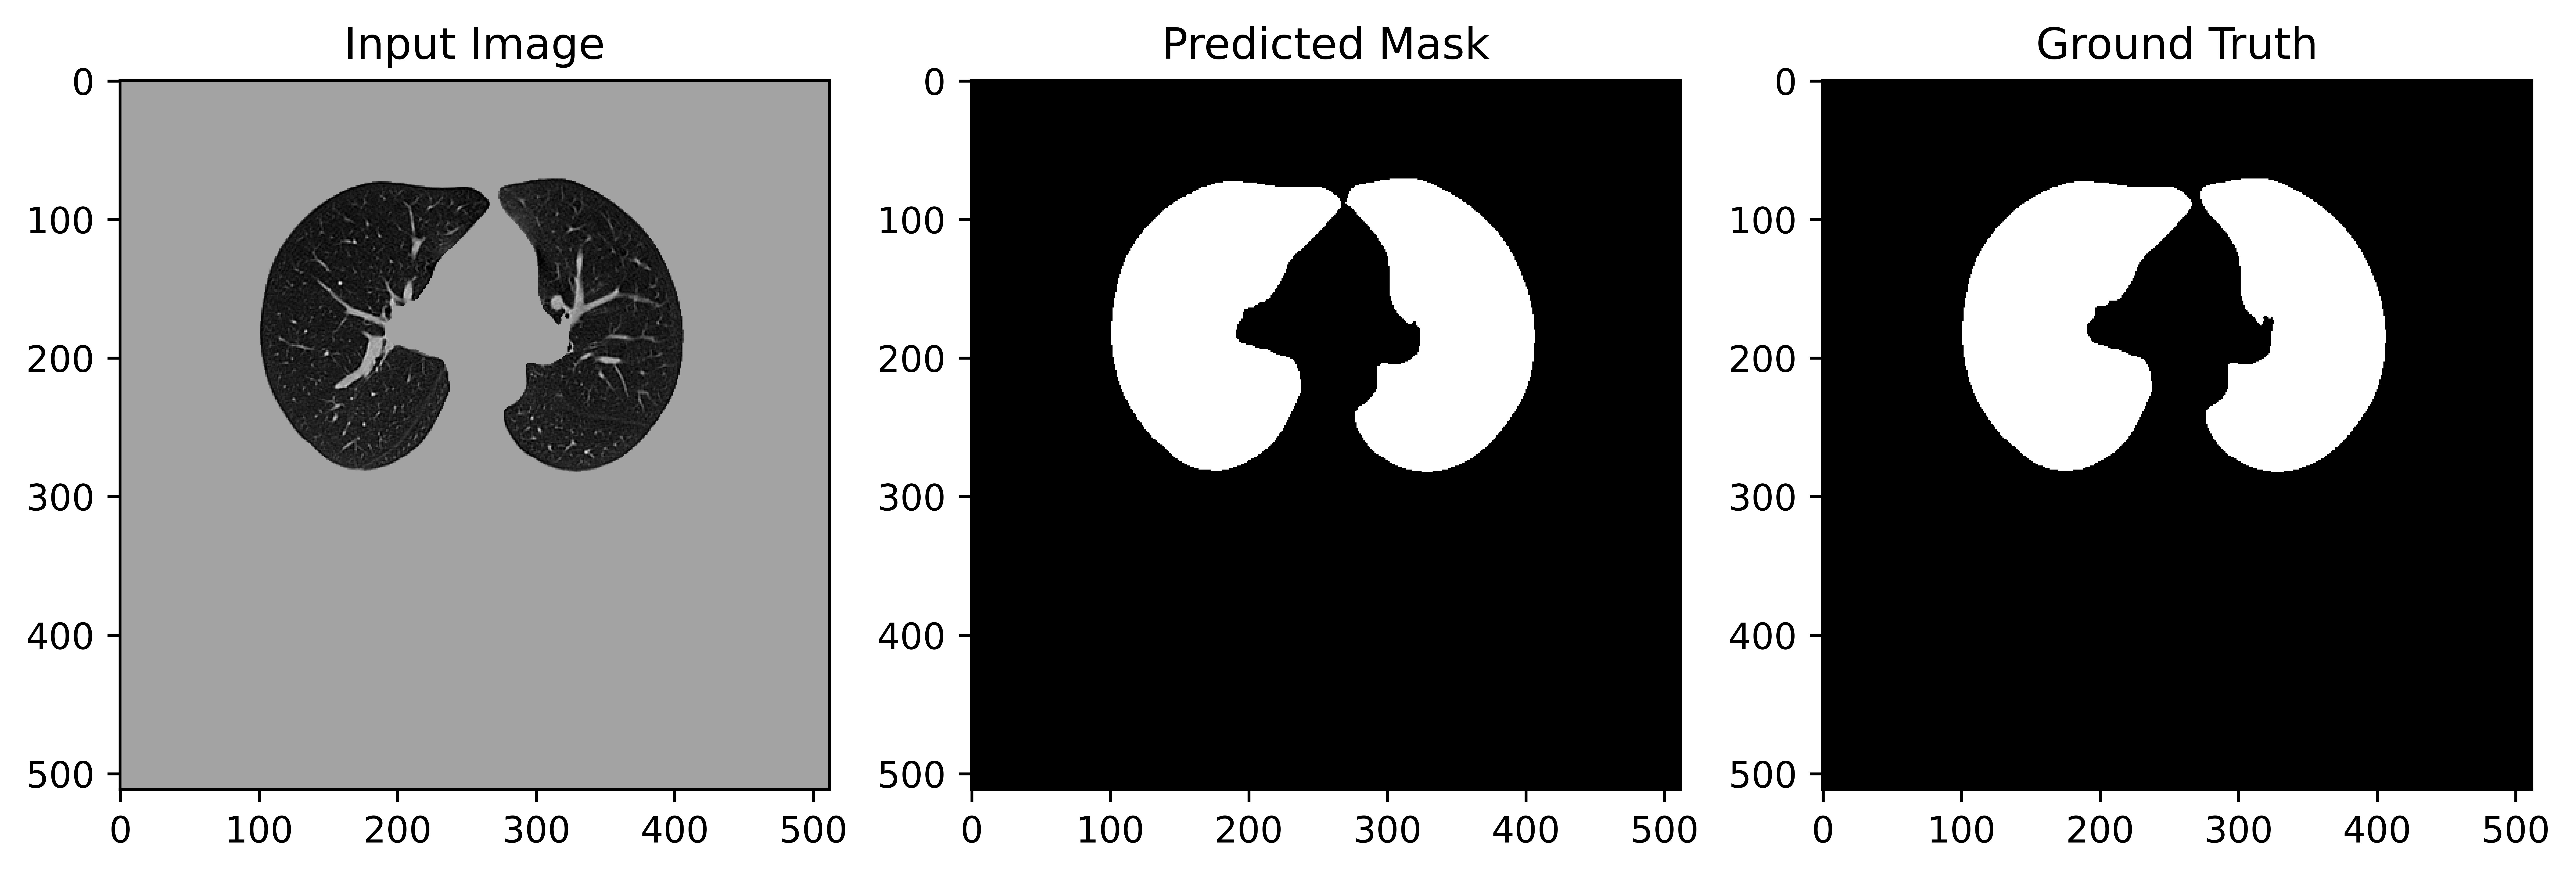

CPU times: user 4min 4s, sys: 3.87 s, total: 4min 7s
Wall time: 1min 14s


In [12]:
%%time
# Loading the Model:
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_valid_accuracy = checkpoint['best_valid_accuracy']

# Initialize variables
correct = 0
total = 0
dice_r = 0
num_classes = 3
confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)
test_loader_iter = tqdm(test_loader, desc='Testing', position=0)

# Ensure model is in evaluation mode
model.eval()

with torch.no_grad():
    for itr, batch in enumerate(test_loader_iter):
        images, masks = batch
        images = images.to(device)
        masks = masks.to(device)
        
        outputs = model(images)
        predicted = torch.argmax(outputs*2., 1)

        #Dice Score
        dice_score = dice(outputs, masks.type(torch.int)).cpu().numpy()
        dice_r += dice_score
        masks = masks.cpu().numpy()
        predicted = predicted.cpu().numpy()
        
        # Flatten the arrays for accuracy calculation
        masks_flat = masks.reshape(-1)
        predicted_flat = predicted.reshape(-1)

        # Update confusion matrix
        for i in range(len(predicted_flat)):
            confusion_matrix[int(masks_flat[i]), int(predicted_flat[i])] += 1

        # Update correct and total counts
        total += masks_flat.shape[0]
        correct += np.sum(predicted_flat == masks_flat)

    accuracy = 100 * correct / total
    sensitivity = confusion_matrix[1, 1] / (confusion_matrix[1, 0] + confusion_matrix[1, 1])
    specificity = confusion_matrix[0, 0] / (confusion_matrix[0, 0] + confusion_matrix[0, 1])

    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Sensitivity: {sensitivity:.2f}')
    print(f'Specificity: {specificity:.2f}')
    print(f'Avg Dice Score: {dice_r/(itr+1):.2f}')

    # Visualize a few results
    for i in range(min(1, images.shape[0])):
        input_image = images[i].cpu().numpy()
        predicted_mask = outputs[i].argmax(0).cpu().numpy()
        ground_truth = masks[i]

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title('Input Image')
        plt.imshow(input_image[0], cmap='gray')
        plt.subplot(1, 3, 2)
        plt.title('Predicted Mask')
        plt.imshow(predicted_mask, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title('Ground Truth')
        plt.imshow(ground_truth, cmap='gray')
        plt.show()

    # Clean up to release GPU memory
    del images, masks, outputs
    torch.cuda.empty_cache()
    gc.collect()
      